In [1]:
import os

import numpy as np
import matplotlib.pyplot as plt

import pandas as pd

import tensorflow as tf

import tensorflow_hub as hub
import tensorflow_text as text
# import tensorflow_datasets as tfds
# tfds.disable_progress_bar()

# from official.modeling import tf_utils
# from official import nlp
# import official.nlp.bert as bert

# from official.nlp.bert.tokenization import FullTokenizer

# Load the required submodules
# import official.nlp.optimization
# import official.nlp.bert.bert_models
# import official.nlp.bert.configs
# import official.nlp.bert.run_classifier
# import official.nlp.bert.tokenization
# import official.nlp.data.classifier_data_lib
# import official.nlp.modeling.losses
# import official.nlp.modeling.models
# import official.nlp.modeling.networks

from sklearn.model_selection import train_test_split

> https://towardsdatascience.com/multi-label-text-classification-using-bert-and-tensorflow-d2e88d8f488d

In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

2022-07-23 22:32:47.912754: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-23 22:32:47.938741: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-23 22:32:47.939586: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


In [3]:
df_full = pd.read_csv('/home/joker/Workspace/Playground/product_classification/datasets/toxic-comment/train.csv')
df_test = pd.read_csv('/home/joker/Workspace/Playground/product_classification/datasets/toxic-comment/test.csv')

In [4]:
train, test = train_test_split(df_full, test_size=0.2)

In [21]:
list_classes = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]

x_train = train["comment_text"]
y_train = train[list_classes]

x_test = test["comment_text"]
y_test = test[list_classes]

In [44]:
y_train.shape

(1000, 6)

In [57]:
train_dataset = tf.data.Dataset.from_tensor_slices((x_train.values, y_train.values)).batch(64)

In [59]:
target_train = tf.keras.utils.to_categorical(y_train.values, 6)

In [62]:
target_train.shape

(1000, 6, 2)

In [6]:
preprocessor = hub.KerasLayer("../models/bert_preprocessor")
encoder = hub.KerasLayer("../models/hub_bert_model")

2022-07-23 22:32:56.204050: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-07-23 22:32:56.204685: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-23 22:32:56.205143: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-23 22:32:56.205418: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zer

In [ ]:
# hub_url_bert = "https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3"

In [ ]:
# gs_folder_bert = "gs://cloud-tpu-checkpoints/bert/v3/uncased_L-12_H-768_A-12"
# tf.io.gfile.listdir(gs_folder_bert)

In [ ]:
# # Set up tokenizer to generate Tensorflow dataset
# tokenizer = FullTokenizer(
#     vocab_file=os.path.join(gs_folder_bert, "import tensorflow_hub as hub
# import tensorflow_text as textvocab.txt"),
#      do_lower_case=True)

# print("Vocab size:", len(tokenizer.vocab))

In [7]:
from keras import backend as K

def balanced_recall(y_true, y_pred):
    """This function calculates the balanced recall metric
    recall = TP / (TP + FN)
    """
    recall_by_class = 0
    # iterate over each predicted class to get class-specific metric
    for i in range(y_pred.shape[1]):
        y_pred_class = y_pred[:, i]
        y_true_class = y_true[:, i]
        true_positives = K.sum(K.round(K.clip(y_true_class * y_pred_class, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true_class, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        recall_by_class = recall_by_class + recall
    return recall_by_class / y_pred.shape[1]

def balanced_precision(y_true, y_pred):
    """This function calculates the balanced precision metric
    precision = TP / (TP + FP)
    """
    precision_by_class = 0
    # iterate over each predicted class to get class-specific metric
    for i in range(y_pred.shape[1]):
        y_pred_class = y_pred[:, i]
        y_true_class = y_true[:, i]
        true_positives = K.sum(K.round(K.clip(y_true_class * y_pred_class, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred_class, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        precision_by_class = precision_by_class + precision
    # return average balanced metric for each class
    return precision_by_class / y_pred.shape[1]

def balanced_f1_score(y_true, y_pred):
    """This function calculates the F1 score metric"""
    precision = balanced_precision(y_true, y_pred)
    recall = balanced_recall(y_true, y_pred)
    return 2 * ((precision * recall) / (precision + recall + K.epsilon()))

In [36]:
def get_embeddings(sentences):
    '''return BERT-like embeddings of input text
    Args:
    - sentences: list of strings
    Output:
    - BERT-like embeddings: tf.Tensor of shape=(len(sentences), 768)
    '''
    preprocessed_text = preprocessor(sentences)
    return encoder(preprocessed_text)['pooled_output']

In [8]:
def get_model(num_classes):
    i = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
    x = preprocessor(i)
    x = encoder(x)
    x = tf.keras.layers.Dropout(0.2, name="dropout")(x['pooled_output'])
    x = tf.keras.layers.Dense(num_classes, activation='softmax', name="output")(x)

    return tf.keras.Model(i, x)

In [9]:
model = get_model(6)

In [10]:
METRICS = [
      tf.keras.metrics.CategoricalAccuracy(name="accuracy"),
      balanced_recall,
      balanced_precision,
      balanced_f1_score
]

In [11]:

earlystop_callback = tf.keras.callbacks.EarlyStopping(monitor = "val_loss", 
                                                      patience = 3,
                                                      restore_best_weights = True)

In [ ]:
loss_scc = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=False, reduction="auto", name="sparse_categorical_crossentropy"
)

In [37]:
model.compile(optimizer = "adam",
              loss = loss_scc,
              metrics = METRICS)

In [13]:
n_epochs = 5

In [14]:
x_train.shape

(1000,)

In [40]:
train_dataset.take(1)

<TakeDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 6), dtype=tf.int64, name=None))>

In [38]:
model_fit = model.fit(train_dataset,
                      epochs = n_epochs,
                      callbacks = [earlystop_callback])

Epoch 1/5


ValueError: in user code:

    File "/home/joker/.virtualenvs/tensorflow_lastest/lib/python3.9/site-packages/keras/engine/training.py", line 1051, in train_function  *
        return step_function(self, iterator)
    File "/home/joker/.virtualenvs/tensorflow_lastest/lib/python3.9/site-packages/keras/engine/training.py", line 1040, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/home/joker/.virtualenvs/tensorflow_lastest/lib/python3.9/site-packages/keras/engine/training.py", line 1030, in run_step  **
        outputs = model.train_step(data)
    File "/home/joker/.virtualenvs/tensorflow_lastest/lib/python3.9/site-packages/keras/engine/training.py", line 894, in train_step
        return self.compute_metrics(x, y, y_pred, sample_weight)
    File "/home/joker/.virtualenvs/tensorflow_lastest/lib/python3.9/site-packages/keras/engine/training.py", line 987, in compute_metrics
        self.compiled_metrics.update_state(y, y_pred, sample_weight)
    File "/home/joker/.virtualenvs/tensorflow_lastest/lib/python3.9/site-packages/keras/engine/compile_utils.py", line 501, in update_state
        metric_obj.update_state(y_t, y_p, sample_weight=mask)
    File "/home/joker/.virtualenvs/tensorflow_lastest/lib/python3.9/site-packages/keras/utils/metrics_utils.py", line 70, in decorated
        update_op = update_state_fn(*args, **kwargs)
    File "/home/joker/.virtualenvs/tensorflow_lastest/lib/python3.9/site-packages/keras/metrics/base_metric.py", line 140, in update_state_fn
        return ag_update_state(*args, **kwargs)
    File "/home/joker/.virtualenvs/tensorflow_lastest/lib/python3.9/site-packages/keras/metrics/base_metric.py", line 646, in update_state  **
        matches = ag_fn(y_true, y_pred, **self._fn_kwargs)
    File "/home/joker/.virtualenvs/tensorflow_lastest/lib/python3.9/site-packages/keras/metrics/metrics.py", line 269, in <lambda>  **
        lambda y_true, y_pred: metrics_utils.sparse_categorical_matches(  # pylint: disable=g-long-lambda
    File "/home/joker/.virtualenvs/tensorflow_lastest/lib/python3.9/site-packages/keras/utils/metrics_utils.py", line 885, in sparse_categorical_matches
        y_true = tf.squeeze(y_true, [-1])

    ValueError: Can not squeeze dim[1], expected a dimension of 1, got 6 for '{{node Squeeze}} = Squeeze[T=DT_INT64, squeeze_dims=[-1]](ArgMax)' with input shapes: [?,6].


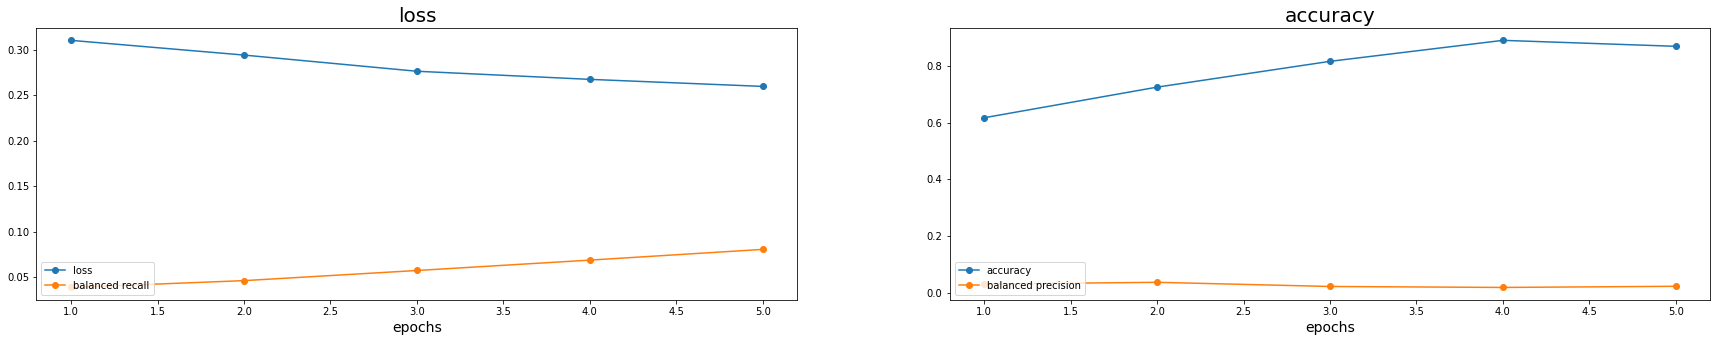

In [24]:
x = list(range(1, n_epochs+1))
metric_list = list(model_fit.history.keys())
num_metrics = int(len(metric_list)/2)

fig, ax = plt.subplots(nrows=1, ncols=num_metrics, figsize=(30, 5))

for i in range(0, num_metrics):
    ax[i].plot(x, model_fit.history[metric_list[i]], marker="o", label=metric_list[i].replace("_", " "))
    ax[i].plot(x, model_fit.history[metric_list[i+num_metrics]], marker="o", label=metric_list[i+num_metrics].replace("_", " "))
    ax[i].set_xlabel("epochs",fontsize=14)
    ax[i].set_title(metric_list[i].replace("_", " "),fontsize=20)
    ax[i].legend(loc="lower left")

In [25]:
def predict_class(reviews):
    '''predict class of input text
    Args:
    - reviews (list of strings)
    Output:
    - class (list of int)
    '''
    return [np.argmax(pred) for pred in model.predict(reviews)]

In [27]:
predict_class(x_train[0:5])


1/1 [==============================] - 0s 42ms/step


[0, 0, 0, 0, 0]

In [12]:
# def encode_sentence(s, tokenizer):
#     tokens = list(tokenizer.tokenize(s))
#     tokens.append('[SEP]')
#     return tokenizer.convert_tokens_to_ids(tokens)

In [13]:
# def bert_encode(data, tokenizer):
#     num_examples = len(data)

#     sentence1 = tf.ragged.constant([encode_sentence(s, tokenizer) for s in np.array(data)])


#     cls = [tokenizer.convert_tokens_to_ids(['[CLS]'])]*sentence1.shape[0]
#     input_word_ids = tf.concat([cls, sentence1], axis=-1)

#     input_mask = tf.ones_like(input_word_ids).to_tensor()

#     type_cls = tf.zeros_like(cls)
#     type_s1 = tf.zeros_like(sentence1)
#     input_type_ids = tf.concat(
#       [type_cls, type_s1], axis=-1).to_tensor()

#     inputs = {
#       'input_word_ids': input_word_ids.to_tensor(),
#       'input_mask': input_mask,
#       'input_type_ids': input_type_ids}

#     return inputs

In [ ]:
# df_train = bert_encode(train["comment_text"], tokenizer)
# df_test = bert_encode(test["comment_text"], tokenizer)

2022-07-23 21:16:48.081414: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 3159505800 exceeds 10% of free system memory.
2022-07-23 21:17:02.963308: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 3159505800 exceeds 10% of free system memory.


NameError: name 'bert_encode' is not defined